In [49]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import multiprocessing
import matplotlib.pyplot as plt

In [20]:
class data_proc():
    
    def process_zip():
        #dealing with zipcode
        zip_data=pd.read_csv('ZIP.csv')
        zip_data['Zip']=zip_data['Zip'].astype(str)
        for i in range(len(zip_data['Zip'])):
            if len(zip_data['Zip'][i])==4:
                zip_data['Zip'][i]='0'+zip_data['Zip'][i]
        zip_data['Zip']=[zip_data['Zip'][i][0:3] for i in range(len(zip_data))] 
        zip_data.iloc[:,-3:]=zip_data[['Median','Mean','Pop']].apply(lambda x: x.str.replace(',',''))
        for i in range(1,4):
            zip_data.iloc[:,-i]=pd.to_numeric(zip_data.iloc[:,-i],errors='coerce')
        zip_data['weight']=zip_data['Pop']/zip_data.groupby('Zip')['Pop'].transform(sum)
        zip_data['new_mean']=zip_data['Mean']*zip_data['weight']
        zip_data['new_median']=zip_data['Median']*zip_data['weight']
        zip_new=pd.DataFrame()
        zip_new=zip_data.groupby('Zip')['new_mean','new_median'].sum()
        return zip_new
        
    def readcsv():
        LARGE_FILE = "C:\\Users\Administrator\Desktop\practicum_regression\loan_data_no_current_converted.csv"
        CHUNKSIZE = 100000 # processing 100,000 rows at a time
        reader = pd.read_csv(LARGE_FILE, chunksize=CHUNKSIZE, low_memory=False)
        frames = []
        for df in reader:
            frames.append(df)
        loan_data = pd.concat(frames)
        return loan_data   
    def cleaning(df,zip_new,keep_desc=True,categorical_to_binary=True):
        df=df.dropna(axis=0,how='all')
        drop_list=['installment','term','settlement_date','pymnt_plan','hardship_length', 'settlement_percentage', 'settlement_term', 'sec_app_earliest_cr_line','policy_code','hardship_end_date','settlement_amount',
           'payment_plan_start_date','hardship_start_date','out_prncp','emp_title','title','earliest_cr_line','desc','issue_d','id','member_id','url','grade','sub_grade',
                   'int_rate','avg_cur_bal','out_prncp_inv','debt_settlement_flag_date','hardship_amount','hardship_reason','addr_state','funded_amnt','funded_amnt_inv','collection_recovery_fee',
                   'collections_12_mths_ex_med','mths_since_last_major_derog','next_pymnt_d','recoveries','total_pymnt',
                   'total_pymnt_inv','total_rec_int','last_pymnt_d','last_credit_pull_d',
                  'total_rec_prncp','settlement_status','hardship_loan_status','hardship_status','debt_settlement_flag',
                   'verification_status','total_rec_late_fee','verification_status_joint','hardship_flag', 'hardship_type', 'hardship_reason',
                    'hardship_status','hardship_loan_status','acc_now_delinq','delinq_amnt','deferral_term','hardship_amount',
                    'hardship_length','hardship_dpd','hardship_payoff_balance_amount','hardship_last_payment_amount']
        df.drop(drop_list,inplace=True,axis=1,errors='ignore')
        #deal with percentage mark
        df['revol_util']=df['revol_util'].replace('%','',regex=True).astype('float')/100
        #merge zipcode with census data
        df['zip_code']=df['zip_code'].apply(lambda x: x[:3])
        df=df.join(zip_new,on='zip_code')
        df.drop('zip_code',inplace=True,axis=1)
        #drop the observation that was missing for ALL field
        df=df.dropna(axis=0,how='all')
        #drop the features for which greater than 10% of the loans were missing data for
        num_rows=df.count(axis=0)
        df=df.iloc[:,(num_rows>=0.8*len(df)).tolist()]
        #drop the observation that was missing for any field
        df=df.dropna(axis=0,how='any')
        #label the dataset to create y
        #0:fully paid, does not meet policy:fully paid
        #1:Does not meet the credit policy. Status:Charged Off",default,charge of
        df=df[(True^df['loan_status'].isin([4]))] 
        df=df[(True^df['loan_status'].isin([5]))]
        df=df[(True^df['loan_status'].isin([6]))] 
        #label the dataset to create y
        y=df['loan_status'].replace(1,0)
        y=y.replace(2,0)
        y=y.replace(3,1)
        y=y.replace(7,1)
        y=y.replace(8,1)
        df=df.drop(['loan_status'],axis=1) 
        return df,y

In [53]:
df1 = data_proc.readcsv()

In [54]:
len(df1)

891823

In [24]:
drop_list=['installment','term','settlement_date','pymnt_plan','hardship_length', 'settlement_percentage', 'settlement_term', 'sec_app_earliest_cr_line','policy_code','hardship_end_date','settlement_amount',
           'payment_plan_start_date','hardship_start_date','out_prncp','emp_title','title','earliest_cr_line','desc','issue_d','id','member_id','url','grade','sub_grade',
                   'int_rate','avg_cur_bal','out_prncp_inv','debt_settlement_flag_date','hardship_amount','hardship_reason','addr_state','funded_amnt','funded_amnt_inv','collection_recovery_fee',
                   'collections_12_mths_ex_med','mths_since_last_major_derog','next_pymnt_d','recoveries','total_pymnt',
                   'total_pymnt_inv','total_rec_int','last_pymnt_d','last_credit_pull_d',
                  'total_rec_prncp','settlement_status','hardship_loan_status','hardship_status','debt_settlement_flag',
                   'verification_status','total_rec_late_fee','verification_status_joint','hardship_flag', 'hardship_type', 'hardship_reason',
                    'hardship_status','hardship_loan_status','acc_now_delinq','delinq_amnt','deferral_term','hardship_amount',
                    'hardship_length','hardship_dpd','hardship_payoff_balance_amount','hardship_last_payment_amount']

In [55]:
def readcsv_FE():
        LARGE_FILE = "C:\\Users\Administrator\Desktop\practicum_regression\This_week_FE.csv"
        CHUNKSIZE = 100000 # processing 100,000 rows at a time
        reader = pd.read_csv(LARGE_FILE, chunksize=CHUNKSIZE, low_memory=False)
        frames = []
        for df in reader:
            frames.append(df)
        loan_data = pd.concat(frames)
        return loan_data 

In [56]:
df2 = readcsv_FE()

In [57]:
df = pd.concat([df1,df2],axis=1)

In [58]:
df['coll_to_cur'].replace('#DIV/0!',0.01177,inplace=True)
df['ratio_rev_acct'].replace('#DIV/0!',0.42676,inplace=True)
df['loan_amt_to_avg_inc'].replace('#DIV/0!',0,inplace=True)

In [59]:
zipdata = data_proc.process_zip()
x,y = data_proc.cleaning(df,zipdata,keep_desc=False,categorical_to_binary=True)

In [62]:
len(x.columns)

59

In [63]:
len(x)

657786

In [64]:
class log_reg():
    # Evaluate the model by splitting into train and test sets
    def split(x,y,rand=0):
        
        y = np.ravel(y)
        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25,random_state=rand)
        
        return x_train, x_test, y_train, y_test 
    #we need to add validation dataset here
    
    # Find binary column method one
    def bool_cols(df,isbool=True):
        bool_cols=[]
        for col in df:
            if isbool==True:
                if df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
            else:
                if not df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
        return bool_cols
    # this above step is to facilitate normalization later
    # method two
    def not_bi(x):
        not_bi=[]
        for i in list(x):
            u=x[i].unique()
            if not (0 in u and 1 in u and len(u)==2): #if not binary
                not_bi.append(i)
        return not_bi
    
    def reg(x_train, y_train):
           
        model = LogisticRegression(penalty='l2',class_weight='balanced',solver='sag',n_jobs=-1)
        
        """
        Why we need standardize?
        
        Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features 
        with approximately the same scale. You can preprocess the data with 
        a scaler from sklearn.preprocessing.
        """
        
        model = model.fit(x_train, y_train)
        
        return model
    
    def ModelValuation(x_test,y_test,model):
        
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        plt.figure(1)
        plt.plot(fpr, tpr, label='LogisticRegression')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
        print("Area Under the Curve (AUC) from prediction score is %f" % metrics.roc_auc_score(y_test, probs[:, 1]))
    
        return None  
    
    def y_pred(x_test,threshold=0.5):
        
        if threshold == 0.5:
            y_predicted = model.predict(x_test)
        else:
            probs = model.predict_proba(x_test)
            y_predicted = np.array(probs[:,1] >= threshold).astype(int)
        
        return y_predicted    
    
    def GetScores(y_test,y_predicted):
        #G means score 
        CM = metrics.confusion_matrix(y_test, y_predicted)
        TN = CM[0,0]
        FN = CM[1,0]
        TP = CM[1,1]
        FP = CM[0,1]
        
        sensitivity = float(TP)/float(TP+FN)
        specificity = float(TN)/float(TN+FP)
        G = np.sqrt(sensitivity*specificity)
        print("G score is %f" % G)
        print("Specificity is %f" % specificity)
        
        # Generate and display different evaluation metrics
        print("Mean accuracy score is %f" % metrics.accuracy_score(y_test, y_predicted))
          
        print("Confusion Marix")
        print(CM)
        
        return specificity , G
        
    # Convenience function to plot confusion matrix
    def confusion(y_test,y_predicted,title):
        
        # Define names for the three Iris types
        names = ['Default', 'Not Default']
    
        # Make a 2D histogram from the test and result arrays
        pts, xe, ye = np.histogram2d(y_test, y_predicted, bins=2)
    
        # For simplicity we create a new DataFrame
        pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
        
        # Display heatmap and add decorations
        hm = sns.heatmap(pd_pts, annot=True, fmt="d")
        hm.axes.set_title(title)
        
        return None
            
    def find_threshold(x_test,y_test):
    
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        sensitivity = tpr
        specificity = 1 - fpr
        G = np.sqrt(sensitivity*specificity)
        
        plt.figure(2)
        plt.plot(thresholds,G)
        plt.xlabel('Thresholds')
        plt.ylabel('G-Scores')
        plt.title('G-Scores with different thresholds')
        plt.show()
        
        
        print("The highest G score is %f with threshold at %f" % (np.amax(G),thresholds[np.argmax(G)]) )
        
        return thresholds[np.argmax(G)]
    # this is just testing, we add weight so we don't need to adjust threshold

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
F:\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

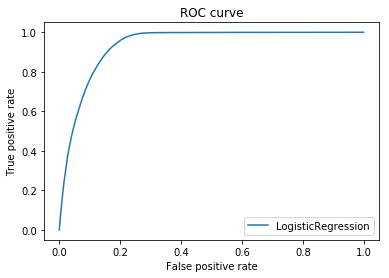

Area Under the Curve (AUC) from prediction score is 0.934670
G score is 0.873911
Specificity is 0.788450
Mean accuracy score is 0.826984
Confusion Marix
[[101930  27349]
 [  1103  34065]]


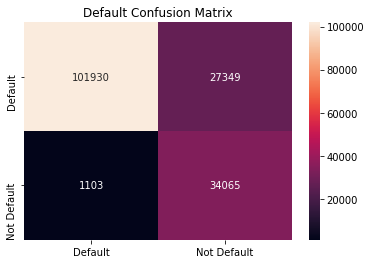

In [66]:
# Split
x_train, x_test, y_train, y_test = log_reg.split(x,y,rand=None)
# Normalize
not_bi = log_reg.not_bi(x)
scaler = StandardScaler()
scaler.fit(x_train[not_bi]) 

x_train_scaled=x_train
x_test_scaled=x_test

x_train_scaled[not_bi] = scaler.transform(x_train[not_bi])
x_test_scaled[not_bi]  = scaler.transform(x_test[not_bi])

# Fit model
model = log_reg.reg(x_train_scaled,y_train)
# Evaluate model
log_reg.ModelValuation(x_test_scaled,y_test,model)
y_predicted = log_reg.y_pred(x_test_scaled,threshold=0.5)
spec , G = log_reg.GetScores(y_test,y_predicted)
log_reg.confusion(y_test,y_predicted,'Default Confusion Matrix')